# Assignment 2: Keeping Up With Social Information (Part 2)
## © Cristian Danescu-Niculescu-Mizil 2020
## CS/INFO 4300 Language and Information
## Due by midnight on Wednesday February 5th

This assignment is **individual**.

In this assignment we will further build upon our analysis of the transcripts from the reality TV show "Keeping Up With The Kardashians" from where we left off since Assignment 1. We will try to uncover some simple social dynamics that are shown through language using various statistical and linguistic techniques to better understand conversational behavior.

**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* Text similarity measures (standard/generalized Jaccard similarity)
* Plotting heatmaps in `matplotlib`
* Advanced numpy functionality
* Interaction strength
* Social interaction analysis 
* Character priming
* Conversation analysis 

**Academic Integrity and Collaboration**

Note that these projects should be completed individually. As a result, all University-standard academic integrity guidelines must be followed.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.

You are unable to modify the read-only cells.

Do not delete the cells for optional questions, even if you do not choose to answer them.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented within a given amount of time to ensure that your logic is correct.

For free-response questions you will be manually graded on the quality of your answer.

**Submission**

This entire notebook is expected to run with an upper bound being ~1-2 minutes.

Also make sure to remove any **redundant print statements** to speed things up and prevent generating unnecessary outputs.

You are expected to submit this .ipynb as your submission for Assignment 2. 

In addition please submit an html copy of the notebook (You can create this by clicking File > Download as > HTML (.html)).

In [392]:
import re
import json
import os
from io import StringIO
import pickle

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# Imports that might help with various functionality
import functools
import operator

# For testing
from numpy.testing import assert_almost_equal 

In [393]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

To ensure that you are comfortable moving forward. Make sure that you are familair with the following data structures that were defined in Assignment 1, as you will be using these throughout Assignment 2:
* deduped_transcripts
* good_types
* word_matrix
* good_speakers

In [394]:
## We are loading: deduped transcripts from Assignment 1
with open('deduped_transcripts.pickle', 'rb') as f:
    deduped_transcripts = pickle.load(f)
## We are loading: the good_types from Assignment 1
with open('good_types.pickle', 'rb') as f:
    good_types = pickle.load(f) 
n_good_types = len(good_types)
## We are loading: the word_matrix from Assignment 1
with open('word_matrix.pickle', 'rb') as f:
    word_matrix = pickle.load(f) 
good_speakers = [u'BRUCE',
                 u'JONATHAN',
                 u'KHLOE',
                 u'KIM',
                 u'KOURTNEY',
                 u'KRIS',
                 u'ROBERT',
                 u'SCOTT']
n_good_speakers = len(good_speakers)

In [395]:
# Ensure that the pickled data stuctures are correct
assert type(deduped_transcripts[0]) == tuple
assert n_good_types == 4517
assert n_good_speakers == 8

# Character interaction analysis

## Question 1 (Code Completion): Character Similarity w/ Jaccard
We will begin by looking at which characters speak most similarly to each other. To analyze this, you will build a symmetric character-by-character matrix showing how similar each pair of characters is, then plot this matrix as a heatmap using `matplotlib imshow`. We will be using Jaccard similarity for this analysis. 

Jaccard similarity is a metric for comparing sets:

$$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} $$

To fit the definition, we represent a character as a set of all words they use (as usual, we only consider "good types"). Note that this formulation involves disregarding how many *times* a speaker said a word.

Therefore, the definition can be rewritten as:

$$ J(A, B) = \frac{\sum_{w \in \text{good types}} w \in A \,\text{and}\, w \in B}
{\sum_{w \in \text{good types}}w \in A \,\text{or}\, w \in B} $$

Since set intersection and union are symmetric operations, it follows that Jaccard similarity is also a symmetric. So:

$$ J(A, B) = J(B, A) $$

In the cell below, fulfill the function specification:

In [637]:
def create_j_sim_mat(input_n_speakers, input_word_matrix, input_good_types):
    """Returns a numpy array of shape n_speakers by n_speakers such that the 
    entry (i,j) indicates the Jaccard similarity between speakers i and j.
    
    Hint: Use numpy primitives. Recall that input_word_matrix is of dimension
    n_good_speakers x n_good_types, where (i,j) is the number of times speaker i
    says word j

    
    Params: {input_n_speakers: Integer,
             input_word_matrix: Numpy array,
             input_good_types: List}
    Returns: Numpy array
    """
    # YOUR CODE HERE
    J = np.zeros([input_n_speakers, input_n_speakers])
    for i in range(input_n_speakers):
        for j in range(input_n_speakers):
            common_words = []
            dot_product = input_word_matrix[i]*input_word_matrix[j]
            for item in dot_product:
                if item !=0:
                    common_words.append(item)
                    
            total_words = []
            array_sum = input_word_matrix[i]+input_word_matrix[j]
            for item in array_sum:
                if item !=0:
                    total_words.append(item)
                    
            J[i,j] = len(common_words)/len(total_words)
    return J

In [638]:
j_sim_matrix = create_j_sim_mat(n_good_speakers, word_matrix, good_types)

In [639]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_j_sim_mat returns the correct output"""
assert type(j_sim_matrix) == np.ndarray
assert j_sim_matrix.shape == (8, 8)
assert j_sim_matrix[4][4] == 1
assert_almost_equal(round(j_sim_matrix[2][5], 1), 0.5)

To make our heatmap more interpretable we have explicitly set the range of our heatmap gradient using `vmin` and `vmax`. This means that values less than `vmin` will have the same shade as `vmin` (white) and that values more than `vmax` will have the same shade as `vmax` (black).

Try varying `vmin` and `vmax` to get a better sense of speaker similarities.

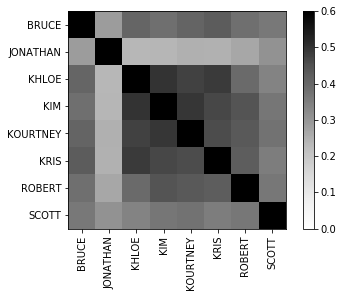

In [640]:
plt.imshow(j_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys, vmin=0, vmax=0.6)
plt.colorbar()

plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show()

## Question 1b (Code Completion) Character Similarity w/ Jaccard
To better understand the relative uniqueness of speakers, we will examine average similarity measurements for each character. You will build a dictionary that contains the mean similarity measurement for each speaker ignoring the speaker's self-similarity measurement. This function should take an arbitrary matrix (for the sake of future analysis that we will do) that is ordered by `good_speakers`.

Please define the function below which returns a dictionary with the following format:

```
{(CHARACTER_NAME_A): avg_score_a,
 (CHARACTER_NAME_B): avg_score_b,
...}
```

In [641]:
def avg_sim_dict(input_sim_matrix, input_good_speakers):
    """Returns a dictionary with the keys being speakers and the values being
    that character's average similarity scores with all other characters.
    
    Params: {input_sim_matrix: Numpy Array,
             input_good_speakers: List}
    Returns Dict
    """
    # YOUR CODE HERE
    dic = {}
    input_sim_matrix_dup =  np.copy(input_sim_matrix)
    np.fill_diagonal(input_sim_matrix_dup, 0)
    avg= []
    
    for i in range(len(input_good_speakers)):
        M = np.sum(input_sim_matrix_dup[:,i])/(len(input_good_speakers)-1)
        avg.append(M)
    for i in range(len(input_good_speakers)):
        dic[input_good_speakers[i]] = avg[i]
    return dic

In [642]:
avg_jaccard_sim_dict = avg_sim_dict(j_sim_matrix, good_speakers)

In [643]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that sim_dict returns the correct output"""
assert type(avg_jaccard_sim_dict) == dict
assert avg_jaccard_sim_dict['JONATHAN'] > 0.2
assert avg_jaccard_sim_dict['KHLOE'], 1 > 0.4

## Question 1c (Code Completion): Character Similarity w/ Jaccard

To more easily analyze the relative uniqueness of speakers, where the most unique speaker is the most dissimilar (i.e. lowest similarity score) to the other speakers. We will take an input average similarity dictionary and return the most and least unique speakers and their corresponding average similarity scores. As a result, we want to return a tuple of tuples in the following format:
```
((MOST_UNIQUE_CHARACTER_NAME, LEAST_SIM_SCORE),
 (LEAST_UNIQUE_CHARACTER_NAME, MOST_SIM_SCORE))
```

In [644]:
def most_least_unique_characters(input_avg_sim_dict):
    """Returns a tuple which shows the most and least unique characters. 

    The desired tuple format should be the following
        ((MOST_UNIQUE_CHARACTER_NAME, LEAST_SIM_SCORE),
         (LEAST_UNIQUE_CHARACTER_NAME, MOST_SIM_SCORE))
    
    Params: {input_avg_sim_dict: Dict}
    Returns: Tuple
    """
    # YOUR CODE HERE
    a= np.argmin(list(avg_jaccard_sim_dict.values()))
    b= np.argmax(list(avg_jaccard_sim_dict.values()))
    return ((good_speakers[a],list(input_avg_sim_dict.values())[a]), (good_speakers[b], list(input_avg_sim_dict.values())[b]))

In [645]:
most_least_tup = most_least_unique_characters(avg_jaccard_sim_dict)
print("MOST UNIQUE: {} - {:.2f}".format(*most_least_tup[0]))
print("LEAST UNIQUE: {} - {:.2f}".format(*most_least_tup[1]))

MOST UNIQUE: JONATHAN - 0.26
LEAST UNIQUE: KIM - 0.41


In [646]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that most_least_sim_pairs returns the correct output"""
assert type(most_least_tup) == tuple
assert len(most_least_tup) == 2

## Question 2 (Code Completion): Character Similarity w/ Generalized Jaccard
The similarity measure that we took above doesn't take into account how often the characters say a word. To account for this, we can use Generalized Jaccard, an extension of Jaccard to weighted sets.

For each word $w$ and each character $C$, we compute the frequency weight $\text{tf}(w, C)$ as the ratio between the number of times $C$ says the word $w$, and the total number of words (good types) said by $C$. For example, if we had a character named Ned, and all of the words that he said were "my name is ned stark of house stark" the $\text{tf}(stark, ned)$ would be $\frac{2}{8}$

Generalized Jaccard is:

$$ GJ(A, B) = \frac{\sum_{w \in \text{good types}} \text{min}(\text{tf}(w, A), \text{tf}(w, B))}
{\sum_{w \in \text{good types}} \text{max}(\text{tf}(w, A), \text{tf}(w, B))} $$

Note that Jaccard is equivalent to Generalized Jaccard if the weights are binarized by truncating all positive weights to 1.

Firstly, you will begin by defining a `tf` function below. 

In [647]:
# To help you, we have incuded this variable which is an inverse index for good_types
good_types_reverse_index = {t: i for i, t in enumerate(good_types)}

In [648]:
def tf(word_w, character_c, input_word_matrix):
    """ This function determines the term frequency weight which is the 
    ratio between the number of times an input character C says word W and 
    the total number of words said by character C.
    
    Note: Look at the example in the cell above with: tf(stark,ned). 
          Please use full precision in your answer (do not round). 
          You should use the global variable: good_types_reverse_index
          in this function... for the sake of making a smaller arg list.
          This is different from the (unnormalized) TF you have seen in class.
    
    Params: {word_w: String,
             character_c: Integer (Index within good_speakers),
             input_word_matrix: Numpy array}
    Returns: Float
    """
    # YOUR CODE HERE
    return input_word_matrix[character_c][good_types_reverse_index[word_w]]/(np.sum(input_word_matrix[character_c]))

In [649]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tf returns the correct output"""
assert tf('hi', 3, word_matrix)*100 > 0.10

## Question 2b (Code Completion): Character Similarity w/ Generalized Jaccard
Now you will complete the function specification below, which will return a numpy array 
of character similarities computed via Generalized Jaccard

In [650]:
def create_g_j_sim_mat(tf_method, input_word_matrix, input_good_types, input_n_speakers):
    """Returns a numpy array of shape n_speakers by n_speakers such that the 
    entry (i,j) indicates the Generalized Jaccard similarity between speakers i and j.
    
    Hint: Use numpy primitives and use the tf_method sparingly
    
    Params: {tf_method: Function (a,b,c) -> d,
             input_word_matrix: Numpy Array,
             input_good_types: List,
             input_n_speakers: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    tf_array = input_word_matrix / np.sum(input_word_matrix, axis=1).reshape((8, 1))

    J  = np.zeros((input_n_speakers, input_n_speakers))
    for i in range(input_n_speakers):
        for j in range(input_n_speakers):
            J[i][j] = np.sum(np.min(tf_array[[i,j],:], axis=0))/np.sum(np.max(tf_array[[i,j], :], axis=0))
    return J

In [651]:
g_j_sim_matrix = create_g_j_sim_mat(tf, word_matrix, good_types, n_good_speakers)
g_avg_jaccard_sim_dict = avg_sim_dict(g_j_sim_matrix, good_speakers)

In [652]:
g_most_least_tup = most_least_unique_characters(g_avg_jaccard_sim_dict)
print("MOST UNIQUE: {} - {:.2f}".format(*g_most_least_tup[0]))
print("LEAST UNIQUE: {} - {:.2f}".format(*g_most_least_tup[1]))

MOST UNIQUE: JONATHAN - 0.54
LEAST UNIQUE: KIM - 0.64


In [653]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_g_j_sim_mat returns the correct output"""
assert type(g_j_sim_matrix) == np.ndarray
assert g_j_sim_matrix.shape == (8, 8)
assert type(g_avg_jaccard_sim_dict) == dict
assert g_j_sim_matrix[4][4] == 1
assert_almost_equal(round(g_j_sim_matrix[2][5], 1), 0.7)
assert g_avg_jaccard_sim_dict['JONATHAN'] > 0.5
assert g_avg_jaccard_sim_dict['KHLOE'] > 0.6

In [654]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_g_j_sim_mat and most_least_sim_pairs returns the correct output"""
assert g_most_least_tup[0][0] == 'JONATHAN'

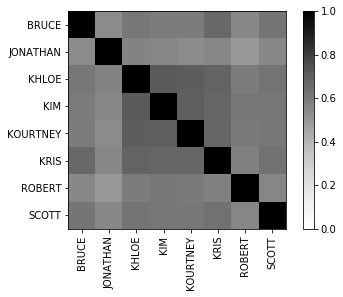

In [655]:
plt.imshow(g_j_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys, vmin=0, vmax=1)
plt.colorbar()

plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show()

## Question 2c (Free Response): Character Similarity w/ Generalized Jaccard

Isn't it cool how we are able to analyze character similarity using just conversational data?! 
Be sure to investigate how the Generalized Jaccard similarity matrix differs from the standard Jaccard matrix and how the character similarity pairs change. 

In the cell below, please use Markdown to observe any differences that you noticed between the heatmaps 
generated with Jaccard and Generalized Jaccard similarity measurements.

YOUR ANSWER HERE

1. In generalized jaccard method, it consider total number of words (good types) said by characters. Usually, when a sentence is long, it is possible that  there  are more words interaction with another sentence.  So to some extend this method is better as it offest "long sentence effect".

2. I sort the avg_jaccard_sim_dict and g_avg_jaccard_sim_dict and get the sort index below:

print(sorted(list(avg_jaccard_sim_dict.values())))

print(np.argsort(list(avg_jaccard_sim_dict.values())))

print(sorted(list(g_avg_jaccard_sim_dict.values())))

print(np.argsort(list(g_avg_jaccard_sim_dict.values())))

Answers:

[0.2617892570484121, 0.3526916004873333, 0.3786915874873376, 0.38744697019752167, 0.40545119477639396, 0.4091071485005812, 0.41351827778098266, 0.41409763835390845]

[1 7 0 6 2 5 4 3]

[0.5411277189194017, 0.5677746811151584, 0.5939768014190295, 0.5988840543411599, 0.6302798839702309, 0.635060698209168, 0.6376412880143689, 0.6409866755258892]

[1 6 0 7 4 5 3 2]

From the difference of sorted index, the top 2 least similar characters using both algotithms are the same, however, the top 2 most similar characters are a little bit different. 

But in general, the effect using both method are similar, we should use general Jaccard method if possible.

## Question 3 (Code Completition): Character Pair Analysis w/ Generalized Jaccard

Leveraging the Generalized Jaccard similarity matrix, g_j_sim_matrix, you will be measure the relative similarity of good speakers. The goal of this analysis is to determine which speaker is the most similar to everyone else and which character is the least similar to everyone else.

To start, we'll build a list of floats of size input_n_speakers that corresponds to the average (mean) similarity between that character and all the rest of the characters (not including self-similarity). In the cell below, satisfy the specification and ensure that you leverage numpy primitives.

In [656]:
def create_avg_sims(input_g_sim,input_n_speakers):
    """Returns a numpy array of size input_n_speaker that gives the average
    (mean) similarity between speaker i and everybody except the speaker itself. 
    
    Hint: It is recommended to use numpy primitives. 
    
    Note: If you can satisfy the spec without using the input_n_speakers arg,
    that is acceptable. 
    
    Params: {input_g_sim: Numpy Matrix (Generalized Jaccard similarity matrix),
             input_n_speakers: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    input_g_sim_dup = np.copy(input_g_sim)
    np.fill_diagonal(input_g_sim_dup, 0)
    for i in range(input_n_speakers):
        A = np.sum(input_g_sim_dup, axis = 1)/(input_n_speakers-1)
    
    return A

In [657]:
avg_sims = create_avg_sims(g_j_sim_matrix,n_good_speakers)

In [658]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_avg_sims returns the correct output"""
assert type(avg_sims) == np.ndarray
assert avg_sims.shape == (8,)
assert sum(avg_sims) < 5

## Question 3b (Code Completition): Character Pair Analysis w/ Generalized Jaccard
This specific analysis concludes with the determination of which characters are the most and least similar to everyone else. 

As such, in the cell bellow satisfy the specification to by return a tuple in the following format:
```
(MOST_SIMILAR_CHARACTER_NAME,LEAST_SIMILAR_CHARACTER_NAME)
```

In [659]:
def most_least_char_sim(input_avg_sims,input_good_speakers):
    """Returns a Tuple which shows the most and least similar character 
       in relation to the rest of the characters. 

    The desired tuple format should be the following
        (MOST_SIMILAR_CHARACTER_NAME,LEAST_SIMILAR_CHARACTER_NAME)
    
    Hint: Use Numpy primitives
    
    Params: {input_avg_sims: Numpy Array,
             input_good_speakers: List}
    Returns: Tuple
    """
    # YOUR CODE HERE
    sort_index = np.argsort(input_avg_sims)
    return (input_good_speakers[sort_index[-1]] , input_good_speakers[sort_index[0]])

In [660]:
sim_pairs = most_least_char_sim(avg_sims,good_speakers)
print("MOST SIMILAR: %s" % sim_pairs[0])
print("LEAST SIMILAR: %s" % sim_pairs[1])

MOST SIMILAR: KHLOE
LEAST SIMILAR: JONATHAN


In [661]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that most_least_char_sim returns the correct output"""
assert type(sim_pairs) == tuple
assert len(sim_pairs) == 2

## Character interactions

In this section we will make the assumption that, if speaker B says something immediately after speaker A, then it is in reply to speaker A's utterance. While this assumption is not correct in all cases (particularly for noisy transcript data) it should still give us some insight into how our characters are behaving. In many cases, making reasonable assumptions about your data can lead to new insights.

## Question 4 (Code Completion): Character Replies

In this question we will be looking at how often each character replies to every other character. Note that here, we consider B to be replying to A **only when speaker A gets a reply from speaker B in the next utterance**. Do not merge consecutive lines by the same speaker as the same speech/reply. For instance, in the example:

```
Line 1: {speaker: A, text: ...}
Line 2: {speaker: A, text: ...}
Line 3: {speaker: B, text: ...}
Line 4: {speaker: B, text: ...}
```
Line 3 should be considered a reply from speaker B to speaker A. 

Line 4 should NOT be considered (part of) a reply from speaker B to speaker A.

In [663]:
def create_reply_matrix(input_deduped_transcripts, input_good_speakers, input_n_speakers):
    """Returns a numpy array of shape n_speakers by n_speakers such that the 
    entry (i,j) indicates the how many times speaker j replied to speaker i.
    
    Params: {input_deduped_transcripts: List,
             input_good_speakers: List,
             input_n_speakers: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    #creat a name dictionary 
    name_dict = {i: j for j,i in enumerate(input_good_speakers)}
    
    reply_matrix = np.zeros((input_n_speakers, input_n_speakers))
    for trans in input_deduped_transcripts:
        speaker1 = 'none'
        speaker2 = trans[1][0]['speaker']
        for dic in trans[1]:
            speaker1 = speaker2
            speaker2 = dic['speaker']
            #print(speaker1, speaker2)
            if (speaker1 in input_good_speakers) and (speaker2 in input_good_speakers):
                reply_matrix[name_dict[speaker1], name_dict[speaker2]]+= 1
    np.fill_diagonal(reply_matrix,0)
    return reply_matrix        
            

In [664]:
reply_matrix = create_reply_matrix(deduped_transcripts, good_speakers, n_good_speakers)

In [665]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_reply_matrix returns the correct output"""
assert type(reply_matrix) == np.ndarray
assert reply_matrix.shape == (8, 8)
assert reply_matrix[1][1] == 0
assert sum(reply_matrix[2]) > 2500
assert sum(reply_matrix[6]) < 950

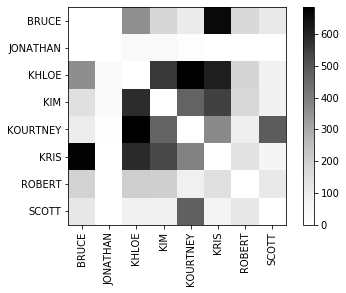

In [666]:
plt.imshow(reply_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show()

## Question 4b (Free Response): Character Replies

In the cell below, use Markdown to describe anything that you notice about the heatmap generated from ``reply_matrix``. What do you notice about the communication between certain characters?

YOUR ANSWER HERE

1. In general, the matrix is not perfectly symmetric, but the difference of the two symmetric elements is not too large. For example reply_matrix[0,2] = 357 and reply_matrix[3,0] = 359. This means that the conversation is continuous. It is within our expectation.

2. From each row, we could get which pairs communicate most in the total transcripts. For example, since reply_matrix[0,5] is quite large = 661, i might guess the connection between BRUCE and KRIS is quite close, and may be they are more similar with each other.

## Question 5 (Code Completion): Character-Pair Specific Reply Diction

In this analysis we will be answering the question: what words were used most specifically by each pair of characters?

For this analysis, we will take only the pairs of characters that exchanged at least 350 messages between them (*good pairs*), in either direction. For example, Speaker A and Speaker B are a *good pair* if A replies to B 175 times and B replies to 175 times.

We will represent these *good pairs* as tuple pairs of character names (ordered alphabetically) and build a matrix where the rows correspond to the pairs, and the columns to the *good type* words.

You will begin by satisfying the specification in the cell below and determining the good pairs. The return type of the function will be a list of tuples in the following format:
```
[(CHARACTER_NAME_A, CHARACTER_NAME_B),
 (CHARACTER_NAME_A, CHARACTER_NAME_C),
...]
```

Note: We will be numerically sorting the good pairs later. 

Hint: You are to only look at the interaction between the pairs, not all words each person says. As such you should be only relying on the `reply_matrix`. 

In [667]:
def create_good_pairs(input_reply_matrix, input_good_speakers, input_n_speakers):
    """Returns a tuple list of good pairs in the following format:
        [(CHARACTER_NAME_A, CHARACTER_NAME_B),
        ...]
    
    Note: Good pairs are bi-directional and should be included only once.
    That is, if (A, B) is in the list, (B, A) should not be. Names should
    be ordered alphbetically within each tuple.
    
    Params: {input_reply_matrix: Numpy array,
             input_n_speakers: Integer}
    Returns: List<Tuple>
    """
    # YOUR CODE HERE
    good_pairs = []
    for i in range(input_n_speakers):
        for j in range(i, input_n_speakers):
            if (input_reply_matrix[i,j] + input_reply_matrix[j,i]>=350):
                good_pairs.append((input_good_speakers[i], input_good_speakers[j]))
    return good_pairs

In [668]:
good_pairs = create_good_pairs(reply_matrix, good_speakers, n_good_speakers)
good_pairs.sort()

In [431]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_good_pairs returns the correct output"""
assert type(good_pairs) == list
assert len(good_pairs) < 15 and len(good_pairs) > 10
assert good_pairs[0] == tuple(sorted(good_pairs[0]))
assert (reply_matrix[tuple([good_speakers.index(s) for s in good_pairs[0]])] + 
        reply_matrix[tuple([good_speakers.index(s) for s in good_pairs[0]][::-1])]) >= 350

In [669]:
# To help you for the next couple of functions. We recommend you use the following variables
# as well as the good_type_reverse_index variable defined before
n_good_pairs = len(good_pairs)
good_pairs_reverse_index = {t: i for i, t in enumerate(good_pairs)}
# We have attached a tokenize method that you should use below:
def tokenize(text):
    """Returns a list of words that make up the text.    
    Params: {text: String}
    Returns: Array
    """
    return [x for x in re.findall(r"[a-z]+", text.lower())]

## Question 5b (Code Completion): Character-Pair Specific Reply Diction

As we continue the analysis we hope to build a character-pair word occurence matrix. This matrix has rows that correspond to *good pairs* and columns that correspond to *good type* words. 

Note that here, like in Question 3, we consider B to be replying to A **only when speaker A gets a reply from speaker B in the next utterance**. Do not merge consecutive lines by the same speaker as the same speech/reply. For instance, in the example:

```
Line 1: {speaker: A, text: ...}
Line 2: {speaker: A, text: ...}
Line 3: {speaker: B, text: ...}
Line 4: {speaker: B, text: ...}
Line 5: {speaker: A, text: ...}
```
If (A, B) is a *good pair*, then
* Line 3 should be included in (A, B)'s reply diction.
* Line 5 should be included in (A, B)'s reply diction.

As such, in the cell below, fulfill the specification to build this `input_n_good_pairs` by `input_n_good_types` matrix:

In [670]:
from collections import Counter
def create_pair_words_mat(input_tokenize_method,
                          input_deduped_transcripts,
                          input_good_speakers,
                          input_n_speakers,
                          input_n_good_types,
                          input_n_good_pairs):
    """Returns a numpy array of shape n_good_pairs by n_good_types such that the 
    entry (i,j) indicates how many times pair i has replied good type word j.
    
    Hint: You should use the global variables good_pairs_reverse_index and 
    good_types_reverse_index.
    
    Params: {input_tokenize_method: Function a -> b,
             input_deduped_transcripts: List,
             input_good_speakers: List,
             input_n_speakers: Integer,
             input_n_good_types: Integer,
             input_n_good_pairs: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    pair_words_mat = np.zeros((input_n_good_pairs, input_n_good_types))
    pair_list = list(good_pairs_reverse_index.keys())
    

    for trans in input_deduped_transcripts:
        speaker1 = 'none'
        speaker2 = trans[1][0]['speaker']
        for dic in trans[1]:
            speaker1 = speaker2
            speaker2 = dic['speaker']
            if speaker1 < speaker2:
                pair = (speaker1, speaker2)
            else:
                pair = (speaker2, speaker1)
            if pair in pair_list:
                word_list = input_tokenize_method(dic['text'])
                counter = Counter(word_list)
                for key, value in counter.items():
                    if key in good_types_reverse_index.keys():
                        pair_words_mat[good_pairs_reverse_index[pair], good_types_reverse_index[key]] += value
    return pair_words_mat

In [671]:
pair_words_mat = create_pair_words_mat(tokenize, deduped_transcripts,
                                       good_speakers, n_good_speakers,
                                       n_good_types, n_good_pairs)

In [672]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_pair_words_mat returns the correct output"""
assert type(pair_words_mat) == np.ndarray
assert pair_words_mat.shape == (n_good_pairs, n_good_types)
assert sum(pair_words_mat[5]) > 2000
assert sum(pair_words_mat[:, 8]) == 0

## Question 5c (Code Completion): Character-Pair Specific Reply Diction

We will finish this analysis by reweighting the character-pair word occurrences such that each entry corresponds to the ratio between how often a given pair says a word and how often all of the *good pairs* said that word. This can be done quite simply with numpy primitives.

In order to de-emphasize the ratios of rare words (i.e. words in rare contexts are more likely to occur for only a single pair), we will apply additive smoothing also known as Laplace smoothing. This means that we will add one to each character-pair word occurrence before reweighting. So, for a given word $w$, pair $p$, amd character-pair word occurrence $\text{count}(p, w)$, the weighted occurrence $W(p, w)$ is

$$ W(p, w) = \frac{\text{count}(p, w) + 1}{\displaystyle\sum_{\pi \in \text{good pairs}} \big(\text{count}(\pi, w) + 1\big)} $$

Below are a few examples of how some ratios will change assuming there are 10 good pairs.

$$
\begin{align*}
\frac{2}{2} = 1.0 \ & \longrightarrow \ \frac{3}{12} = 0.25 \\\\
\frac{50}{50} = 1.0 \  & \longrightarrow \ \frac{51}{60} = 0.85 \\\\
\frac{9}{10} = 0.9 \ & \longrightarrow \ \frac{10}{20} = 0.5
\end{align*}
$$


In the cell below, complete the specification and return the weighted words by each pair:

In [673]:
def create_weighted_words(input_pair_words_mat):
    """Returns a numpy array with the same shape as input_pair_words_mat
    such that entry (i, j) indicates a weighted score showing how often a 
    given pair replied a word
    
    Note: Words may not be said by any pair. Use numpy primitives to
    optimize this function
    
    Params: {input_pair_words_mat: Numpy array}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    input_pair_words_mat_dup = np.copy(input_pair_words_mat)
    return (input_pair_words_mat_dup+1)/(np.sum(input_pair_words_mat_dup, axis =0)+input_pair_words_mat.shape[0])

In [674]:
weighted_words = create_weighted_words(pair_words_mat)

In [675]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_weighted_words returns the correct output"""
assert type(weighted_words) == np.ndarray
assert weighted_words.shape == (n_good_pairs, n_good_types)
assert_almost_equal(weighted_words[-1, 1], 1/9)
assert_almost_equal(round(sum(weighted_words[:, 0]), 5), 1)
assert_almost_equal(round(sum(weighted_words[:, 2]), 5), 1)
assert sum(weighted_words[5]) > 100

Now, we can display the top 10 words between good pairs:

In [454]:
for i, j in good_pairs:
    print("{}, {}".format(i, j))
    words = weighted_words[good_pairs_reverse_index[i, j]]
    ranked = sorted(enumerate(words), key=lambda x:x[1], reverse=True)
    for index, score in ranked[:10]:
        print("{:.2f} {}".format(score, good_types[index]))
    print()

BRUCE, KHLOE
0.56 apparently
0.48 pounds
0.47 armenian
0.41 lose
0.39 american
0.39 coats
0.39 fur
0.37 black
0.37 furs
0.36 few

BRUCE, KRIS
0.58 honey
0.50 atm
0.50 card
0.45 golf
0.42 garage
0.39 enough
0.38 child
0.38 uh
0.37 fabulous
0.37 surgery

BRUCE, ROBERT
0.41 father
0.37 slowly
0.29 yelled
0.28 genetic
0.28 media
0.27 graduated
0.26 club
0.25 exciting
0.22 job
0.22 bonding

KHLOE, KIM
0.41 ta
0.39 gives
0.39 sale
0.38 crying
0.33 takes
0.33 web
0.32 bachelorette
0.32 buying
0.32 dry
0.31 africa

KHLOE, KOURTNEY
0.52 snack
0.44 wave
0.37 peta
0.35 reading
0.35 beast
0.35 compare
0.35 fear
0.35 organization
0.35 palms
0.35 posted

KHLOE, KRIS
0.56 necessary
0.48 wind
0.43 change
0.40 bitch
0.37 purple
0.35 label
0.35 ladies
0.35 maker
0.35 shops
0.35 wanted

KHLOE, ROBERT
0.56 begins
0.33 adrienne
0.31 homeboy
0.30 enjoy
0.29 malika
0.28 robert
0.27 meat
0.26 ya
0.26 freak
0.24 security

KIM, KOURTNEY
0.50 amusing
0.39 buys
0.37 super
0.35 read
0.35 sight
0.35 borrow
0.33 aah

## Question 5d (Free Response): Character-Pair Specific Diction

Now we have some sensible results to understand the specific diction between character pairs. 


In the cell below, please use Markdown to note any interesting observations/analysis you can take-away from the results above. 

YOUR ANSWER HERE

1. BRUCE and KRIS talk about a lot of life entertainment: like atm, card, and golf, and also their child and wife(honey). Beside, maybe they are parent and old so they talk a lot about surgery.

2. KHLOE and KOURTNEY talk a lot of natural science like 'beast', 'wave', 'peta', and 'palms'. They are small children as they talk a lot of 'snack'.

3. KIM and ROBERT  talk about a domestic violence and cheating that happen in adults' world.

## Question 6 (Code Completion): Pair Interaction Strength

In this question we will look at the strength of interactions between *all good speaker pairs* and how that relates to the similarity in their speech. We define interaction strength as the number of interactions between characters.

To do this, we will start by making some modifications to our `reply_matrix`. 
We want an `interaction_matrix` which includes the number of interactions between a pair of characters in total, not just the number of times a character has spoke to another character. Put another way, we want the matrix to be bi-directional and symmetric. To use our example:

```
Line 1: {speaker: A, text....}
Line 2: {speaker: A, text....}
Line 3: {speaker: B, text....}
Line 4: {speaker: B, text....}
```
Line 3 should be considered an interaction between pair (Character A, Character B) as well as pair (Character B, Character A) in the `interaction_matrix`.

In [676]:
def create_interaction_mat(input_reply_matrix, input_n_speakers):
    """Returns a numpy array of shape n_speakers by n_speakers such that the 
    entry (i,j) indicates the combined number of times speaker j started a
    conversation with speaker i and vice versa.
    
    Params: {input_conversation_matrix: Numpy Array,
             input_n_speakers: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    input_reply_matrix_dup = np.copy(input_reply_matrix)
    input_reply_matrix_trans = np.copy(input_reply_matrix).transpose()
    return input_reply_matrix_dup+input_reply_matrix_trans

In [677]:
interaction_matrix = create_interaction_mat(reply_matrix, n_good_speakers)

In [678]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_exchange_mat returns the correct output"""
assert type(interaction_matrix) == np.ndarray
assert interaction_matrix.shape == (8,8)
assert sum(interaction_matrix[0]) > 3000 and sum(interaction_matrix[0]) < 3200
assert sum(interaction_matrix[:,0]) > 3000 and sum(interaction_matrix[:,0]) < 3200

Now let's take a look at how pair interaction strength compares with pair speech similarity. We first do this by looking at  trends for a specific character.

In [458]:
def character_interaction_similarity_plot(input_interaction_matrix, input_similarity_matrix, input_character):
    """Returns a bar plot with for input_character
    x-axis : lists good_speakers in the order of high to low interaction with input_character
    y-axis : generalized jaccard similarity between each good_speaker and input_character pair
    """
    n = good_speakers.index(input_character)
    interaction_order = [idx for idx, sim in sorted(enumerate(interaction_matrix[n]),reverse=True, key=lambda x: x[1])]
    similarity = [g_j_sim_matrix[n][i] for i in interaction_order]
    index = np.arange(n_good_speakers)
    
    plt.bar(index, similarity,color='b')
    
    plt.title(good_speakers[n])
    plt.xlabel('Interaction Strength (high to low)')
    plt.ylabel('Similarity')
    plt.xticks(index, [good_speakers[i] for i in interaction_order])
    
    plt.show()


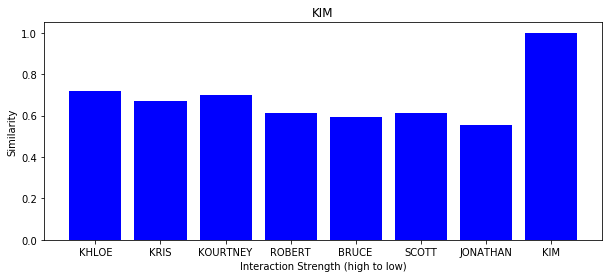

In [679]:
plt.figure(figsize=(10, 4))
character_interaction_similarity_plot(interaction_matrix, g_j_sim_matrix,"KIM")

## Question 6b (Free response): Pair Interaction Strength

In the cell below, use Markdown to describe anything that you notice about how interaction strength compares to similarity for Kim.

YOUR ANSWER HERE

In general, the interaction using interaction_matrix and using generalized jaccard similarity is almost consistent. As we can see from the graph, the relationship with KHLOE is the highest among using jaccard similarity and this KHLOE also comes first in interaction matrix.


## Question 6c (Code Completion): Pair Interaction Strength

To complete your analysis print a bar graph that generalizes the relationship between pair interaction strength and similarity. For simplicity, we rate each pair's interaction strength "high", "medium" and "low" depending on how many interactions were exchanged between the pair.

* High interaction strength: more than 500 interactions,
* Medium interaction strength: 150 interactions to 500 interactions (inclusive),
* Low interaction strength: less than 150 interactions.

In this analysis, categorize each pair into high, medium, or low interaction strength and plot the average similarity of each category. That is, plot 3 bars on the x-axis (1 for each category) against average similarity (for each category) on the y-axis.

Note: Pairs of good speakers are bidirectional in this analysis and should be included only once. That is, if you've included (BRUCE, KRIS), you shouldn't include (KRIS, BRUCE). Also, do not include pairs between the same person (e.g. (KIM,KIM))

Hint: Use interaction_matrix and g_j_sim_matrix

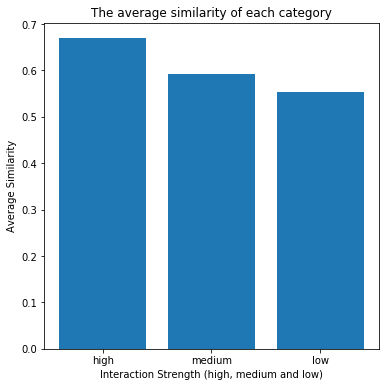

In [680]:
# YOUR CODE HERE
high = []
medium = []
low = []

for i in range(interaction_matrix.shape[0]):
    for j in range(i,interaction_matrix.shape[1]):
        if interaction_matrix[i,j] > 500:
            high.append((i,j))
        elif 150<= interaction_matrix[i,j] <= 500:
            medium.append((i,j))
        elif 0< interaction_matrix[i,j] <150:
            low.append((i,j))
high_similarity_mean = np.mean([g_j_sim_matrix[i][j] for (i,j) in high])
medium_similarity_mean = np.mean([g_j_sim_matrix[i][j] for (i,j) in medium])
low_similarity_mean = np.mean([g_j_sim_matrix[i][j] for (i,j) in low])
mean = [high_similarity_mean, medium_similarity_mean,low_similarity_mean]
index = ['high', 'medium', 'low']

plt.figure(figsize=(6, 6))
plt.bar(index, mean)
    
plt.title("The average similarity of each category")
plt.xlabel('Interaction Strength (high, medium and low)')
plt.ylabel('Average Similarity')

plt.show()


## Question 6d (Free Response): Pair Interaction Strength

These are some interesting connections between interaction strength and speech similarity.
In the cell below, please use Markdown to note any interesting observations/analysis you can take-away from the results above. 

YOUR ANSWER HERE

1. Interaction strength and speech similarity is highly positive related, high interaction strength also means the average similarity is high.

2. This may because, when talk often, then they must have a strong relationship with each other, may be in life or blood relationship.

## Question 7 (Code Completion): Age Group and Social Interaction.

Often we might want to examine how interactions differ depending on the characteristics of the people involved. In this case, we are interested in the extent to which people interact differently depending on the ages of the people they are talking to. 

For example, do people from one age group talk differently to people of other age groups than to people of their own?

For simplicity, we will divide the characters into two age groups and name them P for Parent and C for Child. We provide an age group dictionary below. You are welcome to **additionally** explore on your own other speaker characteristics.  If you find something interesting fill out the optional free response cell below (7d).

We will start by building a matrix with rows corresponding to age group combinations and columns correspodning to good type words. Age group combination (P, C) means that a person from group C is replying to a person from group P. In this analysis, we will consider all interactions, not just the good pairs.

In the cell below, complete the specification by returning the desired Numpy array. 

Hint: You can reuse your helper functions from above or the logic in the your previous methods. <br>
*Note: Only consider the good_types in replies*

In [461]:
# Here we provide you with the age groups for each character 
# and age group combinations of interactions that you will be working with
age_group = {u'BRUCE': u'P',
            u'JONATHAN': u'C',
            u'KHLOE': u'C',
            u'KIM': u'C',
            u'KOURTNEY': u'C',
            u'KRIS': u'P',
            u'ROBERT':u'C',
            u'SCOTT': u'C'}
age_group_index = {'P':0, 'C':1}
age_group_mat_index = {('P', 'P'):0, ('P', 'C'):1, ('C','P'):2, ('C','C'):3}

In [681]:
def create_age_words_mat(input_tokenize_method, input_deduped_transcripts,
                         input_good_speakers, input_n_good_types):
    
    """Returns a numpy array of shape 4 by n_good_types such that the 
    entry (i,j) indicates the how many times age group pair i says word j.
    
    Hint: You should use the global variables:
        good_types_reverse_index,
        age_group,
        age_group_index,
        age_group_mat_index
    
    Params: {input_tokenize_method: Function (a -> b),
             input_deduped_transcripts: List,
             input_good_speakers: List,
             input_n_good_types: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    age_words_mat1 = np.zeros((len(age_group_mat_index), input_n_good_types))
    

    for trans in input_deduped_transcripts:
        speaker1 = 'none'
        speaker2 = trans[1][0]['speaker']
        for dic in trans[1]:
            speaker1 = speaker2
            speaker2 = dic['speaker']
            if (speaker1 != speaker2) and speaker1 in age_group.keys() and speaker2 in age_group.keys(): 
                age_group_type = (age_group[speaker1], age_group[speaker2])
                word_list = input_tokenize_method(dic['text'])
                counter = Counter(word_list)
                for key, value in counter.items():
                    if key in good_types_reverse_index.keys():
                        age_words_mat1[age_group_mat_index[age_group_type], good_types_reverse_index[key]] += value
    return age_words_mat1

In [682]:
age_words_mat = create_age_words_mat(tokenize, deduped_transcripts, good_speakers, n_good_types)

In [683]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_age_words_mat returns the correct output"""
assert type(age_words_mat) == np.ndarray
assert age_words_mat.shape == (4,4517)
assert sum(age_words_mat[1]) > 15000

## Question 7b (Code Completion): Age Group and Social Interaction.

As we finish this portion of the analysis, we end by scoring the words by the ratio between how often a given age group combination said it and how often all of the combinations said it. This can be done quite simply with numpy primitives. As in Question 4, we will use additive smoothing to de-emphasize ratios of less frequent words.

In the cell below, complete the specification and return the weighted words by each age group pair:

Hint: You can reuse your helper functions from above or the logic in the your previous methods. 

In [684]:
def create_age_weighted_words(input_age_words_mat):
    """Returns a numpy array with the same shape as input_age_words_mat
    such that the entry (i,j) indicates a weighted score showing
    how often a given age group pair said a good type word
    
    Hint: Use numpy primitives to make this function optimal
    
    Note: Words may not be said by any age group pair.
    
    Params: {input_age_words_mat: Numpy array}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    input_age_words_mat_dup = np.copy(input_age_words_mat)
    return (input_age_words_mat_dup+1)/(np.sum(input_age_words_mat_dup, axis =0)+input_age_words_mat_dup.shape[0])

In [685]:
age_weighted_words = create_age_weighted_words(age_words_mat)

In [686]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_gender_weighted_words returns the correct output"""
assert type(age_weighted_words) == np.ndarray
assert age_weighted_words.shape == (4,4517)
assert_almost_equal(round(sum(age_weighted_words[:,0]), 5), 1)
assert_almost_equal(age_weighted_words[0, 1], 0.1)

In [687]:
for i, j in age_group_mat_index.keys():
    print(i, j)
    words = age_weighted_words[age_group_mat_index[(i, j)]]
    ranked = sorted(enumerate(words), key=lambda x:x[1], reverse=True)
    for index, score in ranked[:10]:
        print('{:.2f} {}'.format(score, good_types[index]))
    print()

P P
0.64 surgery
0.62 chris
0.62 garage
0.62 planners
0.62 atm
0.60 bored
0.60 card
0.57 brake
0.57 fluffy
0.57 local

P C
0.82 apparently
0.79 necessary
0.73 wind
0.70 coats
0.70 desperate
0.70 fur
0.67 insensitive
0.64 furs
0.64 yours
0.63 mom

C P
0.70 american
0.70 bunny
0.70 genetic
0.70 hop
0.69 alcoholic
0.67 addiction
0.67 appropriate
0.67 backup
0.67 cards
0.67 cranky

C C
0.90 afraid
0.84 bible
0.83 ugly
0.83 reading
0.82 begins
0.82 cheating
0.81 acceptable
0.81 freak
0.81 able
0.81 eyes



## Question 7c (Free Response): Age Group and Social Interaction.

These are some interesting results in regards to uncovering age group and the social interaction between age group pairs. 


In the cell below, please use Markdown to note any interesting observations/analysis you can take-away from the results above. 

YOUR ANSWER HERE

1. Parents themselves tend to talk about medical stuff (because they are old and need sugery sometimes). They also talk a lot about work and their boring life.

2. If children are replying their parents, children address ‘Mom’ respectfully, besides, they tend to reply with very affirmative words like: apperent and necessary, maybe they are too you to be mature.

3. If parents are replying their children, they might call their baby 'Bunny', besides, they might worry about the health of their child, so they may persuade them to keep away from 'alcoholic', 'addiction' or any 'cranky' behaviour.

4. If children are talking with each other, they will talk a lot about gossips, using words like 'ugly', 'cheating' and 'freak'

## Question 7d (Free Response): Other Characteristics and Social Interaction. (Optional)

We might want to examine how interactions differ depending on other characteristics of the people involved. 
You are welcome to **additionally** explore on your own other characteristics of the people. If you find something interesting fill out the optional free response cell below.<br>
While no extra points will be awarded for this task, it may help you with your A2EC assignment.


In [481]:
# YOUR CODE HERE

## Priming. How much is a character's word choice influenced by the person they are speaking to?

<a href=https://en.wikipedia.org/wiki/Priming_(psychology)>Priming</a> is the phenomenon where a speaker tends to repeat certain words or language characteristics of the person they are replying to. It turns out that priming can often be observed in conversation. If A is talking to B, B will sometimes mirror A's language.

## Question 8 (Code Completion): Character Priming

In this analysis we will be looking at priming: i.e. when speaker B replies to speaker A, what is the probability that a word said by A will be repeated by B? 

That is, how many of the words in B's reply were also said by A (normalized by the number of words B said in total)?
Specifically, consider the following example:

```
Catelyn : Hi Ned, it is a really nice day today. Yes, it is.
Ned : It is a really really nice day today. Yes.
```

We should take the set of all words said by Catelyn $W_c = \{ \text{hi}, \text{ned}, \text{it}, \text{is}, \text{a}, \text{really}, \text{nice}, \text{day}, \text{today}, \text{yes}\}$ and the set of all words said by Ned $W_n = \{ \text{it}, \text{is}, \text{a}, \text{really}, \text{nice}, \text{day}, \text{today}, \text{yes}\}$, and compute the *priming computation*:

$$\frac{\left|W_c \cap W_n\right|}{\left|W_n\right|}$$

For a specific *ordered* pair of speakers A and B, we calculate the *arithmetic mean* of priming computations among all instances of B replying to A to get a single number between 0 and 1 as the answer to this question. That is, sum up the primed proportion for every B's reply to A and divide it by the number of times B replied to A.

The next couple methods will walk you through necessary pre-computations to get this priming matrix.
Do read through these functions carefully as you will be using their results.

In [584]:
def merge_deduped(transcripts):
    """Merges adjacent transcript lines by the same speaker"""
    result = [] 
    for t_id, tscript in transcripts:
        prev_speaker = tscript[0]['speaker']
        prev_line = tscript[0]['text']
        tscript_result = [] 
        for i in range(1, len(tscript)): 
            curr_speaker = tscript[i]['speaker']
            curr_line = tscript[i]['text']
            if curr_speaker == prev_speaker: 
                prev_line = prev_line + " " + curr_line 
            else: 
                tscript_result.append({'speaker': prev_speaker, 
                                       'text': prev_line})
                prev_speaker = curr_speaker 
                prev_line    = curr_line 
            if i == len(tscript)-1: 
                tscript_result.append({'speaker': prev_speaker, 
                                        'text': prev_line})
        result.append((t_id, tscript_result))
    return result 

merged_deduped_transcripts = merge_deduped(deduped_transcripts) 

def prev_lines_and_replies(A, B, tscript): 
    """Creates an array of all the transcript lines 
    involving supposed correspondence between A 
    (first speaker) and B (second speaker), both
    previous message and current message"""
    
    # Prepare results for B responses to A, 
    # previous speak 
    result = []
    prev_speaker = None 
    prev_line = None
    
    # Go through every line of the transcript 
    for line in tscript:
        curr_speaker = line['speaker']
        
        # If dialogue has happened 
        if ((curr_speaker == B and prev_speaker == A)): 
            # Add the previous line and the current line 
            result.append([prev_line, line])
        
        # Update the speaker + line 
        prev_speaker = curr_speaker 
        prev_line = line 
            
    return result


def ordered_lines_for_pair(A, B):
    """Gathers all lines in all transcripts for an
    ORDERED pair of characters"""
    
    result = [] 

    for _, tscript in merged_deduped_transcripts:
        result = result + prev_lines_and_replies(A, B, tscript)
    return result 

def ordered_pairs_all_lines():
    """Gathers all lines in all transcripts for all ORDERED pairs 
    of good characters"""
    
    result = dict()  
    
    # Setup pairings (tuples)
    for i in range(0, n_good_speakers):
        for j in range(0, n_good_speakers):
            if i != j:
                tup = (good_speakers[i], good_speakers[j])
                result[tup] = ordered_lines_for_pair(*tup)    
    return result 

# Groupings per pair 
ordered_pairs_lines = ordered_pairs_all_lines()

So, `ordered_pairs_lines` is a data structure containing all of the lines and replies between the pairs of speakers, organized in the following way:

`dict -> list -> list -> dict`
```
(A, B) : [
           [{speaker: A, text: ...}, {speaker: B, text: ...}],
           [{speaker: A, text: ...}, {speaker: B, text: ...}],
           ...
         ]
```

For example (not taken directlt from the transcripts):
```
('BRUCE', 'JONATHAN') : [
                          [{'speaker' : 'BRUCE', 'text': 'The guy's hitting on you, big-time.'},
                           {'speaker' : 'JONATHAN', 'text': 'And I'm out of here early today.'}],
                          [{'speaker' : 'BRUCE', 'text': 'No, I'm not making a scene.'},
                           {'speaker' : 'JONATHAN', 'text': 'What is that?'}],
                         ]
```

In the cell below, fulfill the specification to return a priming matrix:

Note: Ensure that they only good_types are used. If you find that there are no good types in Speaker B's reply, skip that pair of lines (do not add anything to totals or proportions matrices) since there is no priming computation to be done.

In [585]:
def create_pair_priming_mat(tokenize_method, input_ordered_pair_lines,
                            input_good_speakers, input_n_speakers):
    """Returns a numpy array of size n_speakers by n_speakers where entry (i,j) is
    the mean of priming computations (proportions where numerator is the number of 
    good types in j's reply also said by i and denominator is number of good types
    in j's reply) across all pairs of lines where j replied to i.
    
    Hint: Use numpy primitives to make this function optimal.
          You should use the good_types_reverse_index global variable. 
    
    Steps: 
        1. Iterate through each tuple (for each pair i,j)
        2. Grab only good types
        3. Do necessary priming calculations 
    
    Params: {tokenize_method: Function a -> b,
             input_ordered_pairs: Dict,
             input_n_speakers: Integer}
    Returns: Numpy array
    """
                
    # We are providing you the code structure below to help you get
    # started in the right direction. You may edit it, if you want.
    good_types_set = set(good_types_reverse_index.keys())
            
    # Resultant matricies 
    proportions = np.zeros((input_n_speakers, input_n_speakers))
    totals = np.zeros((input_n_speakers, input_n_speakers))
    # All the pairs 
    for pair in input_ordered_pair_lines.keys(): 
        A = pair[0] # A, who is prompting B
        i = input_good_speakers.index(A)
        B = pair[1] # B, who is responding to A
        j = input_good_speakers.index(B)
        # For tuple arrays for each pair 
        for arrs in input_ordered_pair_lines[pair]:
            # Grab sets of words 
            response = tokenize_method(arrs[1]['text'])
            B_sent = set(response)
            A_sent = set(tokenize_method(arrs[0]['text'])) 
            
            # Reduce B_sent to just good types
            # Up the total number of correspondences for each pair
            # Compute priming calculations and sum for each pair
        # YOUR CODE HERE
            proportions[i,j] += len(A_sent & B_sent)
            totals[i,j] += len(B_sent)
    totals[totals == 0] += 1
    answer = proportions / totals # get arithmetic mean
    return answer

In [586]:
pair_priming_mat = create_pair_priming_mat(tokenize, ordered_pairs_lines, good_speakers, n_good_speakers)

In [587]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that pair_priming_mat returns the correct output"""
assert type(pair_priming_mat) == np.ndarray
assert pair_priming_mat.shape == (8, 8)
assert pair_priming_mat[0][0] == 0
assert pair_priming_mat[1][0] == 0
assert sum(pair_priming_mat[5]) > 0.7 and sum(pair_priming_mat[5]) < 0.8

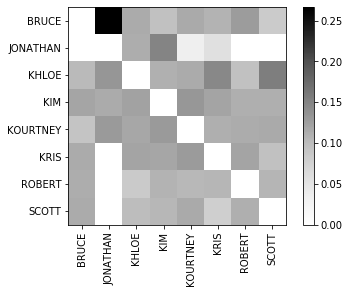

In [588]:
plt.imshow(pair_priming_mat, interpolation='none', cmap=plt.cm.Greys)
plt.colorbar()
plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show() 

Consider the three character pairs with the most priming, as well as the three with the least.

Note that priming is not symmetric. For example, Kim might tend to mimic Kourtney more than the other way around.

In the code we provided below we have ignored *ordered* pairs that have fewer than 100 words. Analyze the code and results provided:

In [589]:
mat_items = []
for i in range(n_good_speakers):
    for j in range(n_good_speakers):
        if i != j and reply_matrix[i, j] >= 100:
            mat_items.append((pair_priming_mat[i, j], (i, j)))
mat_items.sort() 

print("Top 3 pairs:")
top_3_priming_pairs = []
for score, (i, j) in reversed(mat_items[-3:]):
    top_3_priming_pairs.append((i, j))
    print("- {} repeats {} ( score: {:.4f} )".format(good_speakers[j], good_speakers[i], score, 5))
print("Bottom 3 pairs:")
for score, (i, j) in reversed(mat_items[:3]):
    print("- {} repeats {} ( score: {:.4f} )".format(good_speakers[j], good_speakers[i], score, 5))

Top 3 pairs:
- KRIS repeats KHLOE ( score: 0.1466 )
- KOURTNEY repeats KIM ( score: 0.1316 )
- KIM repeats KOURTNEY ( score: 0.1295 )
Bottom 3 pairs:
- BRUCE repeats KOURTNEY ( score: 0.0913 )
- KHLOE repeats ROBERT ( score: 0.0834 )
- SCOTT repeats BRUCE ( score: 0.0828 )


## Question 8b (Free Response): Character Priming

In the cell below, please use Markdown to describe anything that you notice about the heatmap generated from the priming matrix as well as the results above, in regards to the top/bottom 3 priming pairs. Were you expecting these results or are were you surprised?  

YOUR ANSWER HERE

1. From the heatmap, the darkest one is (BRUCE, JONATHAN), which means J mimic a lot from Bruce. However, based on the reply_matrix, this record is deleted from the pair_priming_mat, as this pair have fewer than 100 words.

2. The people whose words are mostly repeated by others are all child and the person whose words are least repeated by others contains parents. This means that children would repeat pears' words while they are not willing to repeat their parents.


## Question 8c (Code Completion): Character Priming
Next we are interested in the actual words that are being repeated in replies and how many times they are being repeated.

In the following example:
```
Catelyn : Hi Ned, it is a really nice day today. Yes, it is.
Ned : It is a really really nice day today. Yes.
```
We see that Ned repeats the words *it*, *is*, *a*, *nice*, *day*, *today*, and *yes* one time, and *really* two times. 

Note that in this analysis, we do not concern ourselves with how many times Catelyn repeats a word. That is, we disregard the fact that Catelyn has said the words *it* and *is* two times. We are only interested if Ned repeats words that Catelyn has said. 

For each of the three most-primed ordered pairs, what are the top 10 *good_types* being repeated? In the cell below, satisfy the specification to return the counts of repeated `good_types` per pair by returning a dictionary of word counts per ordered pair in the following format:

```
{(CHARACTER_NAME_A, CHARACTER_NAME_B): 
    {word_1:count_1, word_2:count_2, ...}
...}
```

In [590]:
## Helper variables for the following cell
ordered_pairs = list(ordered_pairs_lines.keys())
n_ordered_pairs = len(ordered_pairs)
ordered_pair_lookup = {}
for i in range(0, n_ordered_pairs):
    ordered_pair_lookup[ordered_pairs[i]] = i

In [629]:
import copy

def word_counts_per_ordered_pair(tokenize_method, input_ordered_pairs, input_ordered_pairs_lines):
    """Returns a dictionary that contains all the word counts of primed words (good_types)
    per ordered pair in the following format:
        {
         (character_index_a, character_index_b): {word_1:count_1, word_2:count_2...},
         (character_index_a, character_index_c): {word_1:count_1, word_2:count_2...},
                    
        ...}
    
    Hint: Make sure to use the good_types_reverse_index global variable
    
    Note: The dictionary you are returning should contain all word counts of
    primed words(good_types), not just the top 10, and for all pairs, not just the top 3.
    
    Params: {tokenize_method: Function (a -> b),
             input_ordered_pairs: List
             input_ordered_pair_lines: Dict}
    Returns: Dict 
    """
    # YOUR CODE HERE
    a = {}
    for pair in ordered_pairs_lines.keys():
        a_words = []
        b_words = []
        for arrs in ordered_pairs_lines[pair]:
            b_words += tokenize_method(arrs[1]['text'])
            a_words += tokenize_method(arrs[0]['text'])

        common_words = set(a_words) & set(b_words)
        b_count = Counter(b_words)
        a[pair] = {}
        good_types_reverse_index_set = set(good_types_reverse_index.keys())
        for key in common_words:
            if key in good_types_reverse_index_set:
                a[pair][key] = b_count[key]
    return a
            

In [630]:
priming_word_counts = word_counts_per_ordered_pair(tokenize,ordered_pairs,ordered_pairs_lines)

In [631]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that priming_word_counts returns the correct output"""
assert type(priming_word_counts) == dict
assert len(priming_word_counts[('BRUCE', 'JONATHAN')]) > 0
assert len(priming_word_counts[('KRIS', 'KOURTNEY')]) > 100
assert sum(priming_word_counts[('KIM', 'KRIS')].values()) > 1000

## Question 8d (Code Completion): Character Priming
To complete your analysis print the top 10 words used by the top 3 priming pairs. The expected format is the following: 

```
CHARACTER_NAME_A1 CHARACTER_NAME_A2
WORD_1_COUNTS WORD_1
 ...
WORD_10_COUNTS WORD_10

CHARACTER_NAME_B1 CHARACTER_NAME_B2
WORD_1_COUNTS WORD_1
 ...
WORD_10_COUNTS WORD_10

CHARACTER_NAME_C1 CHARACTER_NAME_C2
WORD_1_COUNTS WORD_1
 ...
WORD_10_COUNTS WORD_10

```
Where (A1, A2), (B1, B2), and (C1, C2) represent the top 3 priming pairs.

You can use the global variable `top_3_priming_pairs`

In [633]:
# YOUR CODE HERE
top_3_priming_pairs

for pair in top_3_priming_pairs:
    print(good_speakers[pair[0]]+ ' ' + good_speakers[pair[1]])
    words = priming_word_counts[(good_speakers[pair[0]], good_speakers[pair[1]])]
    sort_tuple = sorted(words.items(), key=lambda x: x[1], reverse=True)
    for i in range(10):
        print (str(sort_tuple[i][1]) + ' ' + sort_tuple[i][0])

KHLOE KRIS
416 you
404 i
322 to
223 s
206 a
182 and
180 the
160 it
149 that
107 khloe
KIM KOURTNEY
315 i
199 to
169 you
128 s
122 and
115 like
113 the
112 t
108 it
104 that
KOURTNEY KIM
378 i
230 you
199 to
147 and
147 it
147 s
122 the
116 like
112 a
109 that


## Question 8e (Free response): Character Priming (Optional)
We have previously defined interaction strength and looked at the relationship between interaction strength and similarity. Here, we might also want to take a look at how interaction strength relates to the level of priming in each pair. That is, do pairs with stronger interaction interaction strength tend to prime more? 
If you are curious, you can fill out this free response cell below and let us know.

While no extra points will be awarded for this task, it may help you with your A2EC assignment.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Can't get enough of language and information?  

We have more!  Check out **A2ExtraCredit** for a chance to analyze Game of Thrones data and get some super-valuable extra credit points.  **Highly recommended**

# This is the end of Assignment 2